# 0. Problem Statement

If we are able to categorize a customer based on the type of language they use when they ask Google Home stock market related questions, we will be able to better tailor marketing strategies, recommended products, and other platform-specific customizations that we can tailor for each customer type. Google's Sales, Service, and Support team has taken on a new, high-revenue generating client in the debt relief space and would like to market to prospective customers that are in need of debt relief, but Google's Sales, Service, and Support team is getting less Google searches for "debt relief" than they had initially anticipated. I recommend targeting users of r/wallstreetbets with the use of Natural Language Processing (NLP) through the Google Home, search, and other integrations. Google Home is currently unable to understand the linguistic nuances of wallstreetbets and thus, further data science exploration into this classification is needed.

With certain nuances in language, how can we differentiate between a consumer that regularly participates in r/wallstreetbets, from a typical individual investor? What words or phrases have the highest impact on classifying between wallstreetbetters and individual investors?

# 1. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import warnings
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score
from xgboost import XGBClassifier
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")

# 2. Pull Data from API / Import / Load Data

## 2.1 Pull Data

In [ ]:
# returns text from r/wallstreetbets
wsb_text_list = utils.get_data('wallstreetbets')
# returns text from r/stocks
rstocks_text_list = utils.get_data('stocks') 

wsb_df = pd.DataFrame(data={
    'text': wsb_text_list,
    # constant number to classify subreddit for classification modeling step
    'is_wsb' : 1 
})

rstocks_df = pd.DataFrame(data={
    'text': rstocks_text_list,
    'is_wsb' : 0 
})

# put the dataframes of both subreddits together
df_merged = pd.concat([wsb_df, rstocks_df])

# output for the rest of the process
df_merged.to_csv('../data/subreddit_data.csv', index=False)

## 2.2 Import / Load Data

In [2]:
df = pd.read_csv('../data/subreddit_data.csv')

# 3. Data Cleaning

In [3]:
# Lowercase text
df['text'] = df['text'].str.lower()

# Drop nulls
df = df.dropna()

# Removing these breaks from text
df['text'] = df['text'].map(lambda x: x.replace('\n', ' '))

# Removing these words from text (result of ampersand)
df['text'] = df['text'].map(lambda x: x.replace('amp', ''))

# because the lemmatizer and stemmer won't
df['text'] = df['text'].map(lambda x: x.replace('stocks', 'stock')) 

# removing documents with links
df = df[~df['text'].str.contains('http')]

# Lemmatizing and stemming because the each method misses some key words that I would like shortened to the root of.
p_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Tokenizing for lemmatizing and stemming
tokenizer = RegexpTokenizer(r'[a-z]\w+')
df['text'] = df['text'].transform(tokenizer.tokenize)

# Lemmatizing and stemming
for list_obj in df['text']:
    [p_stemmer.stem(x) for x in list_obj]
    [lemmatizer.lemmatize(x) for x in list_obj]

# Joining tokenized lists back together
df['text'] = df['text'].map(lambda x: ' '.join(x))

# 4. Exploratory Data Analysis (EDA)

## 4.1 Brief Look at the DataFrame

In [4]:
df.head()

,text,is_wsb
1,laundering drug money,1
2,figured out why wsbers like tsla so much,1
3,nclh put today secured,1
4,back from the dead boys,1
5,uvxy shares puts on rusl calls on lmt dd as fo...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26798 entries, 1 to 28590
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    26798 non-null  object
 1   is_wsb  26798 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 628.1+ KB


In [6]:
df.describe()

,is_wsb
count,26798.000000
mean,0.441861
std,0.496618
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## 4.2 Create Related Features

In [7]:
df['text_len'] = df['text'].transform(len)
df['avg_word_len'] = df['text'].transform(utils.avg_word_len_func)
df['words_in_text'] = df['text'].str.split().transform(len)

In [8]:
# Nulls created in the 'avg_word_len' variable are due to rows with blank text that were missed by the initial df.dropna() called.
df = df[~df['avg_word_len'].isna()]

## 4.3 Summary Statistics of New Features

In [9]:
df.head()

,text,is_wsb,text_len,avg_word_len,words_in_text
1,laundering drug money,1,21,6.333333,3
2,figured out why wsbers like tsla so much,1,40,4.125000,8
3,nclh put today secured,1,22,4.750000,4
4,back from the dead boys,1,23,3.800000,5
5,uvxy shares puts on rusl calls on lmt dd as fo...,1,4236,5.714739,631


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26763 entries, 1 to 28590
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text           26763 non-null  object 
 1   is_wsb         26763 non-null  int64  
 2   text_len       26763 non-null  int64  
 3   avg_word_len   26763 non-null  float64
 4   words_in_text  26763 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.2+ MB


In [11]:
df.describe()

,is_wsb,text_len,avg_word_len,words_in_text
count,26763.000000,26763.000000,26763.000000,26763.000000
mean,0.441430,147.155775,4.698366,26.632963
std,0.496567,434.117041,1.192740,75.677520
min,0.000000,2.000000,2.000000,1.000000
25%,0.000000,26.000000,4.055556,5.000000
50%,0.000000,48.000000,4.500000,9.000000
75%,1.000000,109.000000,5.071429,20.000000
max,1.000000,15659.000000,59.000000,2575.000000


## 4.4 Exploring Features

In [12]:
df['is_wsb'].value_counts(normalize=True)

0    0.55857
1    0.44143
Name: is_wsb, dtype: float64

0.56 is the accuracy score to beat when we reach the modeling phase. 0.56 will act as our null accuracy value as it is the mode. If we were to guess if a post was from r/stocks (value 0), we would be right 56% of the time.

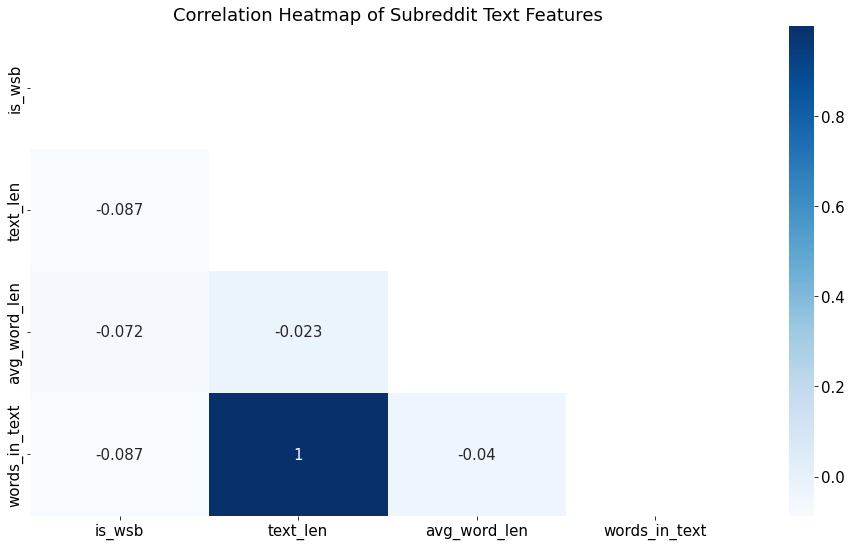

In [13]:
# Formatting from this cell adapted from: https://www.geeksforgeeks.org/how-to-create-a-triangle-correlation-heatmap-in-seaborn-python/

plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 15})
plt.title('Correlation Heatmap of Subreddit Text Features')
mask = np.triu(np.ones_like(df.corr()))

sns.heatmap(
    df.corr(), 
    annot=True, 
    cmap='Blues', 
    mask=mask
);

No notable correlations between any added or pre-existing features except for text_len and words_in_text which is not surprising. Because of this correlation, I won't be performing EDA on both variables, I will only be using one, as results for one will only have the same results as the other.

## 4.5 Exploring Features of Each Subreddit

In [14]:
# Separating the subreddits for EDA
wsb = df[df['is_wsb'] == 1]
rstocks = df[df['is_wsb'] == 0]

In [15]:
# Showing feature averages by subreddit
df.groupby(by='is_wsb').mean()

,text_len,avg_word_len,words_in_text
is_wsb,,,
0,180.565723,4.775003,32.462773
1,104.880058,4.601393,19.256137


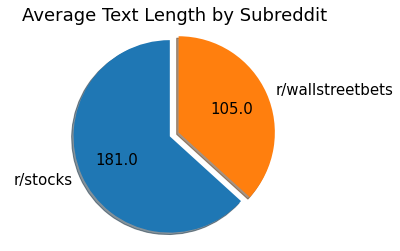

In [16]:
# Function adapted from https://stackoverflow.com/questions/41088236/how-to-have-actual-values-in-matplotlib-pie-chart-displayed
def absolute_value(val):
    """Returns absolute values for display on a plt pie chart."""
    return np.round(val / 100 * sizes.sum(), 0)

labels = ['r/stocks', 'r/wallstreetbets']
sizes = df.groupby(by='is_wsb').mean()['text_len']
explode = (0, 0.1)

plt.rcParams.update({'font.size': 15})
fig1, ax1 = plt.subplots()
ax1.set_title('Average Text Length by Subreddit')
ax1.pie(sizes, explode=explode, labels=labels, autopct=absolute_value,
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [17]:
# Pct difference formula for text length
round(((181 / (181 + 105)) - (105 / (181 + 105))) * 100, 2)

26.57

Posts in r/stocks tend to be about 26% longer than posts in r/wallstreetbets. This is likely due to users in r/stocks performing more due diligence than the users on r/wallstreetbets, along with users on r/wallstreetbets only writing out a short post with a meme or photograph of their gain or loss.

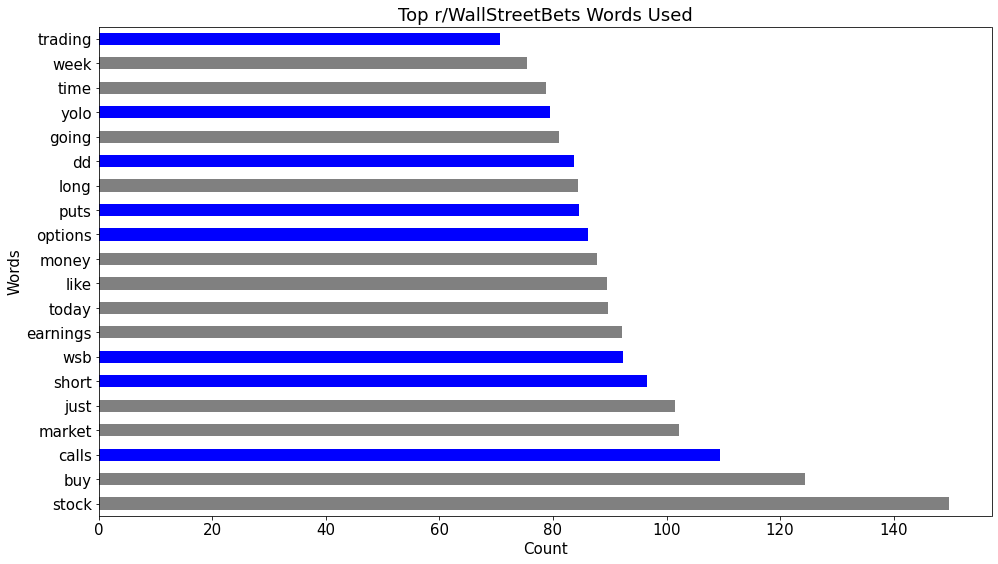

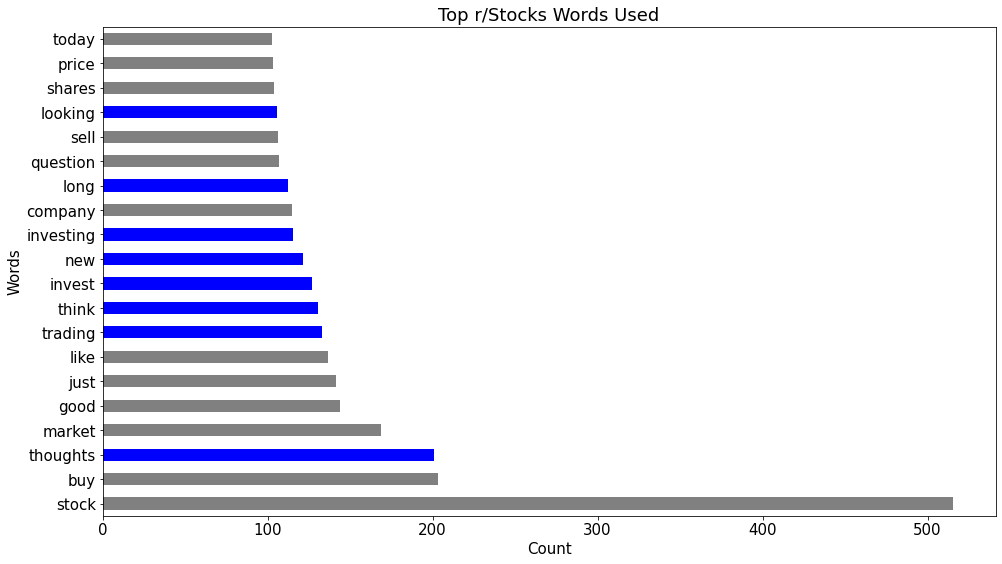

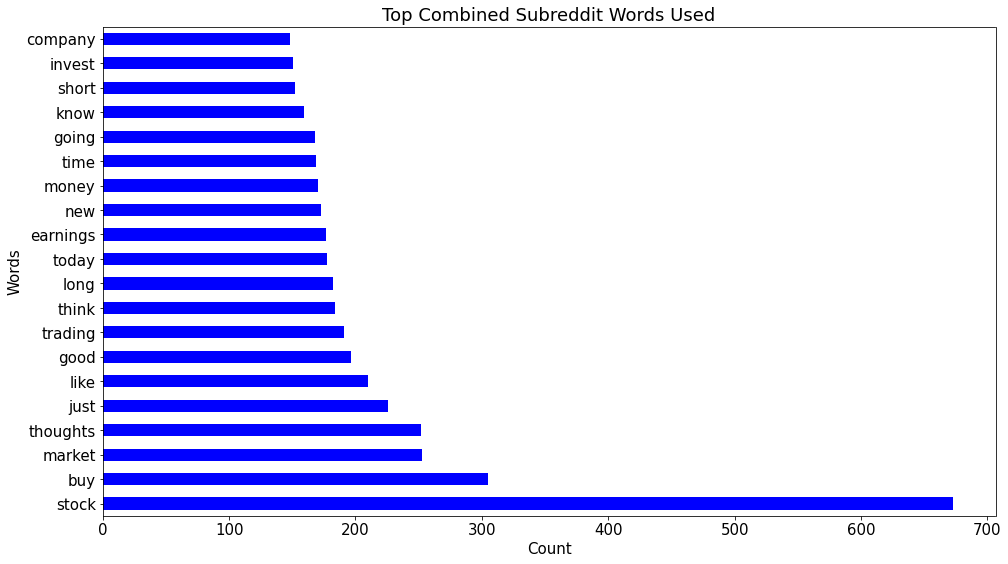

In [18]:
plt.rcParams.update({'font.size': 15})

# Wall Street Bets
color_wsb = ['blue','gray','gray','blue','gray','blue','gray','blue','blue','gray','gray','gray','gray','blue','blue','gray','gray','blue','gray','gray'][::-1]
utils.top_words_plot('r/WallStreetBets', wsb['text'], color_wsb)

# Stocks
color_stocks = ['gray','gray','blue','gray','gray','blue','gray','blue','blue','blue','blue','blue','gray','gray','gray','gray','blue','gray','gray'][::-1]
utils.top_words_plot('r/Stocks', rstocks['text'], color_stocks)

# Combined Dataframe
utils.top_words_plot('Combined Subreddit', df['text'], 'blue')

## 4.6 EDA Findings

- Posts in r/stocks tend to be about 26% longer than posts in r/wallstreetbets. This is likely due to users in r/stocks performing more due diligence than the users on r/wallstreetbets, along with users on r/wallstreetbets only writing out a short post with a meme or photograph of their gain or loss.
- When examining the most popular words from both subreddits, r/wallstreetbets tends to use more words like 'calls', 'puts', and 'yolos', whereas r/stocks tends to use more words like 'investing', indicating the respective trading styles of both subreddits. To no surprise, r/wallstreetbets redditors are focused on high-risk high-reward short-term trades, whereas r/stocks redditors are more focused on *relatively* longer term investing.

# 5. PreProcessing

## 5.1 Train/Test Split & Custom Stopwords

In [19]:
X = df['text']
y = df['is_wsb']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42,
    test_size=0.3,
    stratify=y
)

ERROR! Session/line number was not unique in database. History logging moved to new session 118


We need to create our own stopwords for the modeling process. There are lots of words and phrases that are unique to both subreddits and because of that, pre-built nltk packages may not be able to pick up on certain vocabulary that may not be useful in classifying between r/stocks and r/wallstreetbets. Because of this, the next step is to iterate over multiple Logistic Regression models, take the words that have low coefficients implying less importance in classification, and adding them to a list of stopwords that won't be used in the next iteration. From there, we can remove this list of model-identified stopwords from the list of features and words used and test on multiple classification models to identify the one that performs the best.

In [ ]:
stopwords = []

for num in range(5):

    # Vectorize
    tfidf = TfidfVectorizer(
    stop_words=stopwords,
    ngram_range=(1, 2),
    min_df=20,
    max_df=0.9,
    strip_accents='ascii')

    # Fit/Transform Vectorizer
    X_transform_train = tfidf.fit_transform(X_train)
    X_transform_test = tfidf.transform(X_test)

    # Logistic Regression model prediction
    lr = LogisticRegression()
    lr.fit(X_transform_train, y_train)
    print(f'Iteration {num + 1} Complete')

    # Use low coefficients between 0.5 and -0.5 and add them to the list of stopwords to use in the next iteration
    coefficients = pd.DataFrame(lr.coef_, columns=tfidf.get_feature_names_out()).T
    low_coef_words = coefficients[(coefficients[0] < 0.5) & (coefficients[0] > -0.5)].T.columns
    stopwords.extend(low_coef_words)

# Final Fit/Transform with completed stopwords list
X_transform_train = tfidf.fit_transform(X_train)
X_transform_test = tfidf.transform(X_test)

## 5.2 OverSampling / SMOTE

Pursuing oversampling to account for the class imbalance in the data between r/stocks documents and r/wallstreetbets documents. In theory, this step should reduce the chances of extreme imbalances in classification accuracy and scores between each subreddit.

In [22]:
smo = SMOTE()

X_train_smote, y_train_smote = smo.fit_resample(X_transform_train, y_train)

# 6. Model Selection

In [23]:
# Initialize classifiers
classifiers = {
    'logreg' : LogisticRegression(random_state=42, max_iter=1000),
    'svc' : SVC(random_state=42),
    'linear_svc' : LinearSVC(random_state=42),
    'decision_tree' : DecisionTreeClassifier(random_state=42),
    'random_forests' : RandomForestClassifier(random_state=42),
    'multinomialNB' : MultinomialNB(),
    'knearestneighbors' : KNeighborsClassifier(),
    'bagging' : BaggingClassifier(random_state=42),
    'bag_decision_tree' : BaggingClassifier(random_state=42, n_estimators=100, base_estimator=DecisionTreeClassifier()),
    'adaboost' : AdaBoostClassifier(random_state=42, base_estimator=DecisionTreeClassifier()),
    'xgboost' : XGBClassifier()
}

In [24]:
# Test each base model to find one to optimize
utils.test_models(classifiers, X_train_smote, y_train_smote, X_transform_test, y_test)

,train_recall,test_recall
knearestneighbors,0.894973,0.812641
xgboost,0.862576,0.784989
logreg,0.805715,0.751411
linear_svc,0.813360,0.748589
adaboost,0.958142,0.748589
svc,0.886181,0.730813
random_forests,0.949350,0.712472
bag_decision_tree,0.948872,0.707393
bagging,0.929090,0.694695
decision_tree,0.941609,0.694131


The model that I am going to choose to use for the final steps is XGBoost, as the test data recall score is the one of the highest among the base classifiers. After testing KNearest and XGBoost, XGBoost did a better job of minimizing false negatives, thus I am moving forward with that model.

Why choose recall as the primary metric:

Choosing the primary metric for a classification problem is dependent on the data science or business problem. I am choosing recall as the primary metric here because we are trying to classify and differentiate between wallstreetbetters and individual investors. To have wallstreetbetters falsely labeled as individual investors would be fine and acceptable when considering the types of customized advertising experience they would receive, but to have individual investors falsely labeled as wallstreetbetters would confuse many investors, Google Home users, and internet users alike. This is due to the unique nature of r/wallstreetbets being a subculture within the investing/trading/gambling communities. Thus, we want to prioritize minimizing false negatives and maximize recall score.

              precision    recall  f1-score   support

           0       0.80      0.70      0.75      4485
           1       0.67      0.78      0.72      3544

    accuracy                           0.74      8029
   macro avg       0.74      0.74      0.73      8029
weighted avg       0.75      0.74      0.74      8029



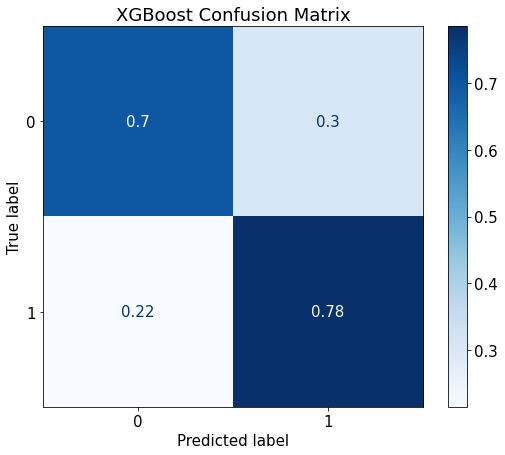

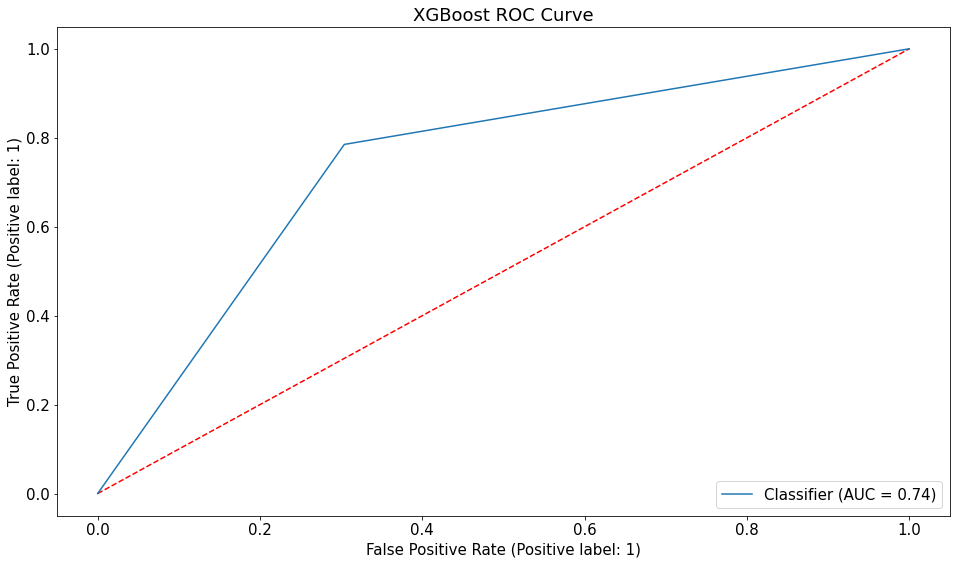

In [27]:
xg = XGBClassifier()
xg.fit(X_train_smote, y_train_smote)

plt.rcParams.update({'font.size': 15})
utils.print_final_results('XGBoost', xg, X_transform_test, y_test)

This model does fairly well at minimizing false positives and maximizing recall. The next step is testing different hyperparameters to try to optimize this model further.

# 7. Model Optimization

In [ ]:
# Gridsearch for optimizing hyperparameters
xg = XGBClassifier()

xg_params = {
    'max_depth' : range(3, 10, 2),
    'min_child_weight' : range(1, 6, 2)
}

gs = GridSearchCV(xg, param_grid=xg_params, cv=5)
gs.fit(X_train_smote, y_train_smote)
print(recall_score(y_test, gs.predict(X_transform_test)))

In [34]:
gs.best_params_

{'max_depth': 9, 'min_child_weight': 1}

In [33]:
gs.best_score_

0.7527719467691417

With an accuracy score of 75%, we were able to beat the null model by about 19% accuracy.

              precision    recall  f1-score   support

           0       0.80      0.71      0.75      4485
           1       0.68      0.78      0.72      3544

    accuracy                           0.74      8029
   macro avg       0.74      0.74      0.74      8029
weighted avg       0.75      0.74      0.74      8029



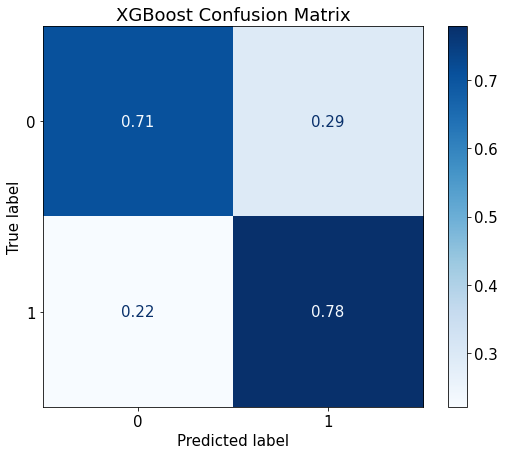

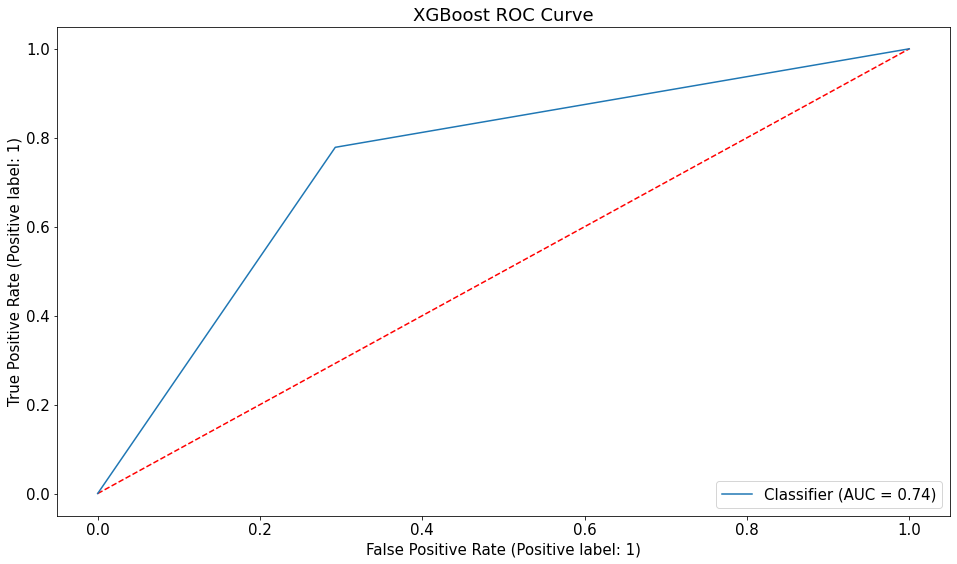

In [29]:
# Printing results of Gridsearch
plt.rcParams.update({'font.size': 15})
utils.print_final_results('XGBoost', gs, X_transform_test, y_test)

From GridSearchCV, we were able to slightly minimize false negatives by approximately 1%.

# 8. Final Insights

In [30]:
# Creating a DataFrame for feature importances for inference
feature_importance_df = pd.DataFrame(
    data=gs.best_estimator_.feature_importances_, 
    index=tfidf.get_feature_names_out(), 
    columns=['feature_importance']).sort_values(
        by=['feature_importance'], 
        ascending=False)

# Removing features with a feature_importance of 0
feature_importance_df = feature_importance_df[feature_importance_df['feature_importance'] != 0].reset_index()

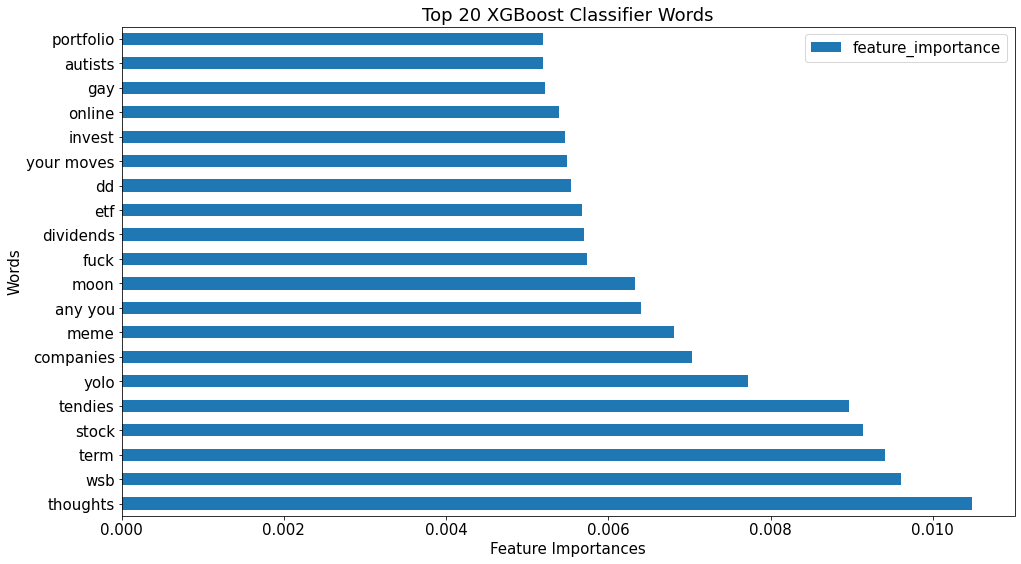

In [32]:
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams.update({'font.size': 15})

# r/WallStreetBets Top 20 Coefficients
feature_importance_df[:20].plot.barh(x='index', y='feature_importance')
plt.title('Top 20 XGBoost Classifier Words')
plt.xlabel('Feature Importances')
plt.ylabel('Words');

Clean / non-profanity words that were identified by the model as important words in determining the classification between r/wallstreetbets and r/strocks, and are evidently related to the r/wallstreetbets community, include:

    - dd
    - moon
    - meme
    - yolo
    - tendies
    - wsb



Recommendations / Next steps:

    - Implement model-weighted r/wallstreetbets specific keywords into the marketing tactics for client
    - Utilize wallstreetbets-specific keyword targeting (identified in Insights section) within Google Home, Google search, and other strategic integrations
    - This model does not take into consideration contextual language so please keep that in mind when taking any action with the insights derived from the model. For example, "moon" is a strong word when classifying between wallstreetbetters and individual investors but only in the context of finance. If a Google home user or Google search user uses the word "moon" in a different context, they should not be labeled as a wallstreetbetter.